## Описание работы

Просмотр фильмов на оргинальном языке - популярный и действенный метод прокачаться при изучении иностранного языка. Важно выбрать фильм, который подходит студенту по уровню сложности, т.ч. студент понимал 50 - 70 % диалогов. 

**Цель проекта:** в течение двух недель разработать ML решение для автоматического определения уровня сложности англоязычных фильмов.

**План работы:**
1. Загрузить и ознакомиться с данными.
2. Провести предобработку данных.
3. Загрузить субтитры в датасет.
4. Подготовить данные для дальнейшего обучения.
5. Определить осноные метрики качества модели.
6. Обучение модели с побором гиперпараметров.
7. Оценка модели на тестовой выборке.

## Загрузка необходимых библиотек

In [1]:
# установим недостающие пакеты
!pip install pysrt
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install optuna
!pip install lightgbm
!pip install ydata-profiling

     --------------------------------------- 12.8/12.8 MB 11.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
conda install -c anaconda py-xgboost

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\VMP.PC\anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2023.7.2~ --> anaconda::ca-certificates-2023.01.10-haa95532_0 
  certifi            conda-forge/noarch::certifi-2023.7.22~ --> anaconda/win-64::certifi-2022.12.7-py310haa95532_0 





Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2




In [3]:
conda install -c conda-forge catboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\VMP.PC\anaconda3

  added / updated specs:
    - catboost


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2023.01.10-~ --> conda-forge::ca-certificates-2023.7.22-h56e8100_0 
  certifi            anaconda/win-64::certifi-2022.12.7-py~ --> conda-forge/noarch::certifi-2023.7.22-pyhd8ed1ab_0 





Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2




In [4]:
# импортируем общие библиотеки
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import re
import string
import seaborn as sns
import itertools
import pickle
import pandas as pd
from numpy.random import RandomState
from scipy.stats import randint
from scipy import stats as st
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 200
import warnings
warnings.filterwarnings("ignore")
import pysrt
import spacy
import xgboost 
import catboost 
import lightgbm
import optuna
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from ydata_profiling import ProfileReport

## Загрузка, анализ и предобработка данных

In [5]:
# загрузим список фильмов с известным уровнем сложности
labels = pd.read_excel('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/English_scores/movies_labels.xlsx',index_col=0)
labels

,Movie,Level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+
...,...,...
236,Matilda(2022),C1
237,Bullet train,B1
238,Thor: love and thunder,B2


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   241 non-null    object
 1   Level   241 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


In [7]:
# распределение фильмов по уровням сложности
labels.Level.value_counts()

B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: Level, dtype: int64

In [8]:
# Упрощение уровней сложности фильмов
labels.loc[labels.Level == 'A2/A2+', 'Level'] = 'A2'
labels.loc[labels.Level == 'B1, B2', 'Level'] = 'B1'
labels.loc[labels.Level == 'A2/A2+, B1', 'Level'] = 'A2'

In [9]:
labels.Level.value_counts()

B2    101
B1     63
C1     40
A2     37
Name: Level, dtype: int64

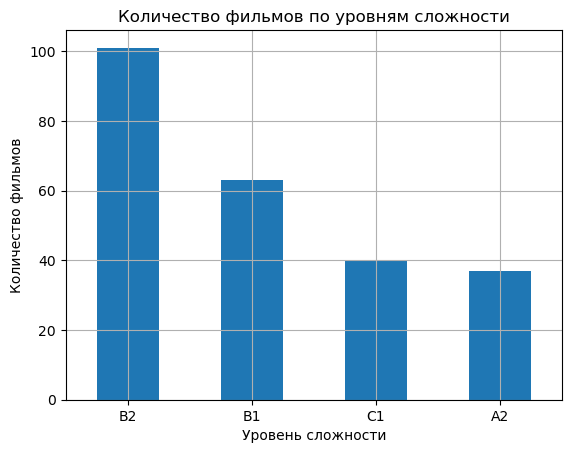

In [10]:
# график количества фильмов в датасете по уровню владения английским языком
labels.Level.value_counts().plot(kind='bar', title='Количество фильмов по уровням сложности', grid=True, 
                                 xlabel='Уровень сложности', ylabel='Количество фильмов', rot=0
);

In [11]:
# проверим данные на наличие дубликатов
labels[labels.duplicated(keep=False)]

,Movie,Level
id,,
38,Powder(1995),B1
43,Inside_out(2015),B1
44,Inside_out(2015),B1
68,Powder(1995),B1


In [12]:
# удалим дубликаты 
labels = labels.drop_duplicates()
labels.shape

(239, 2)

## Загрузка субтитров и словаря

In [13]:
HTML = r'<.*?>' # html тэги меняем на пробел
TAG = r'{.*?}' # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # комменты в скобках меняем на пробел
UPPER = r'[[A-Za-z ]+[\:\]]' # указания на того кто говорит (BOBBY:)
LETTERS = r'[^a-zA-Z\'.,!? ]' # все что не буквы меняем на пробел 
SPACES = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+' # многоточие меняем на точку
SYMB = r"[^\w\d'\s]" # знаки препинания кроме апострофа

def clean_subs(subs):
    subs = subs[1:] # удаляем первый рекламный субтитр
    txt = re.sub(HTML, ' ', subs.text) # html тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) # комменты в скобках меняем на пробел
    txt = re.sub(UPPER, ' ', txt) # указания на того кто говорит (BOBBY:)
    txt = re.sub(LETTERS, ' ', txt) # все что не буквы меняем на пробел
    txt = re.sub(DOTS, r'.', txt) # многоточие меняем на точку
    txt = re.sub(SPACES, r'\1', txt) # повторяющиеся пробелы меняем на один пробел
    txt = re.sub(SYMB, '', txt) # знаки препинания кроме апострофа на пустую строку
    txt = re.sub('www', '', txt) # кое-где остаётся www, то же меняем на пустую строку
    txt = txt.lstrip() # обрезка пробелов слева
    txt = txt.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы   
    txt = txt.lower() # текст в нижний регистр
    return txt

In [14]:
labels['Subtitles']= np.nan
labels

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,NaN
1,10_things_I_hate_about_you(1999),B1,NaN
2,A_knights_tale(2001),B2,NaN
3,A_star_is_born(2018),B2,NaN
4,Aladdin(1992),A2,NaN
...,...,...,...
236,Matilda(2022),C1,NaN
237,Bullet train,B1,NaN
238,Thor: love and thunder,B2,NaN


In [15]:
# Создадим список фильмов
movie_list = labels['Movie'].to_list()

In [16]:
list_not_iclude=[]
for i in range(len(movie_list)):
    try:
        labels.loc[i,'Subtitles'] = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/'+ movie_list[i]+'.srt', encoding='iso-8859-1'))
    except:
        list_not_iclude.append(movie_list[i])
        continue

In [17]:
list_not_iclude

['The Secret Life of Pets.en',
 'Up (2009)',
 'Glass Onion',
 'Matilda(2022)',
 'Bullet train',
 'Thor: love and thunder',
 'Lightyear',
 'The Grinch']

In [18]:
labels

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,michelle please don't hang up just talk to me okay i can't believe you just left michelle come back please say something michelle talk to me look we had an argument couples fight that is no reason...
1,10_things_I_hate_about_you(1999),B1,i'll be right with you so cameron here you go nine schools in years my my army brat yeah my dad is that's enough i'm sure you won't find padua any different than your old schools same little ass w...
2,A_knights_tale(2001),B2,should we help him he's due in the lists in two minutes two minutes or forfeit lend us those right left dead eh three scores to none after two lances as long as sir ector doesn't fall off his hors...
3,A_star_is_born(2018),B2,get to it black eyes open wide it's time to testify there is no room for lies and everyone's waiting for you then i'm gone sitting by the phone and i'm all alone by the wayside and i'm gone sittin...
4,Aladdin(1992),A2,where the caravan camels roam where it's flat and immense and the heat is intense it's barbaric but hey it's home when the wind's from the east and the sun's from the west and the sand in the glas...
...,...,...,...
238,Thor: love and thunder,B2,NaN
239,Lightyear,B2,NaN
240,The Grinch,B1,NaN


In [19]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 68
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Movie      239 non-null    object
 1   Level      239 non-null    object
 2   Subtitles  231 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [20]:
labels.query("Subtitles != Subtitles")

,Movie,Level,Subtitles
id,,,
79,The_Intern(2015),B2,NaN
104,Toy_story(1995),A2,NaN
233,Suits.S03E09.480p.HDTV.x264-mSD,C1,NaN
234,Suits.S03E10.HDTV.x264-mSD,C1,NaN
235,Glass Onion,B2,NaN
236,Matilda(2022),C1,NaN
237,Bullet train,B1,NaN
238,Thor: love and thunder,B2,NaN
239,Lightyear,B2,NaN


In [21]:
labels.loc[240,'Subtitles']=clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/'+'The.Grinch.2018.REMUX.1080p.Blu-ray.AVC.TrueHD.DTS-HD.MA.7.1-LEGi0N.English'+'.srt', encoding='iso-8859-1'))
labels.loc[233,'Subtitles']=clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/'+'Suits.S03E09.480p.HDTV.x264-mSD'+'.srt', encoding='iso-8859-1'))
labels.loc[234,'Subtitles']=clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/'+'Suits.S03E10.HDTV.x264-mSD'+'.srt', encoding='iso-8859-1'))
labels.loc[104,'Subtitles']=clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/'+'Toy_story(1995)'+'.srt', encoding='iso-8859-1'))
labels.loc[79,'Subtitles']=clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/'+'The_Intern(2015)'+'.srt', encoding='iso-8859-1'))

In [22]:
labels.query("Subtitles != Subtitles")

,Movie,Level,Subtitles
id,,,
235,Glass Onion,B2,NaN
236,Matilda(2022),C1,NaN
237,Bullet train,B1,NaN
238,Thor: love and thunder,B2,NaN
239,Lightyear,B2,NaN


У фильмов представленных выше отсутствуют субтитры. Было установленно, что данные фильмы отсутствуют в папке, в следствии чего было решено удалить их из датафрейма.

In [23]:
# удалим фильмы с пропущенными субтитрами
labels.dropna(inplace=True)
# проверим удаление
labels.query("Subtitles != Subtitles")

,Movie,Level,Subtitles
id,,,


In [24]:
labels.query('Subtitles==""')

,Movie,Level,Subtitles
id,,,
207,Downton Abbey - S01E06 - Episode 6.eng.SDH,C1,
208,Downton Abbey - S01E07 - Episode 7.eng.SDH,C1,
209,Suits S04E01 EngSub,C1,
210,Suits S04E02 EngSub,C1,
211,Suits S04E03 EngSub,C1,
212,Suits S04E04 EngSub,C1,
213,Suits S04E05 EngSub,C1,
214,Suits S04E06 EngSub,C1,
215,Suits S04E07 EngSub,C1,


In [25]:
list_errors = labels.query('Subtitles==""')['Movie'].to_list()

In [26]:
sub_1 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Downton Abbey - S01E06 - Episode 6.eng.SDH.srt'))
labels.loc[207,'Subtitles'] = sub_1
sub_2 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Downton Abbey - S01E07 - Episode 7.eng.SDH.srt'))
labels.loc[208,'Subtitles'] = sub_2
sub_3 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E01 EngSub.srt'))
labels.loc[209,'Subtitles']=sub_3
sub_4 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E02 EngSub.srt'))
labels.loc[210,'Subtitles']=sub_4
sub_5 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E03 EngSub.srt'))
labels.loc[211,'Subtitles']=sub_5
sub_6 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E04 EngSub.srt'))
labels.loc[212,'Subtitles']=sub_6
sub_7 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E05 EngSub.srt'))
labels.loc[213,'Subtitles']=sub_7
sub_8 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E06 EngSub.srt'))
labels.loc[214,'Subtitles']=sub_8
sub_9 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E07 EngSub.srt'))
labels.loc[215,'Subtitles']=sub_9
sub_10 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E08 EngSub.srt'))
labels.loc[216,'Subtitles']=sub_10
sub_11 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E09 EngSub.srt'))
labels.loc[217,'Subtitles']=sub_11
sub_12 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E10 EngSub.srt'))
labels.loc[218,'Subtitles']=sub_12
sub_13 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E11 EngSub.srt'))
labels.loc[219,'Subtitles']=sub_13
sub_14 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E12 EngSub.srt'))
labels.loc[220,'Subtitles']=sub_14
sub_15 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E13 EngSub.srt'))
labels.loc[221,'Subtitles']=sub_15
sub_16 = clean_subs(pysrt.open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/Subtitles/Suits S04E14 EngSub.srt'))
labels.loc[222,'Subtitles']=sub_16

In [27]:
labels.query('Subtitles==""')

,Movie,Level,Subtitles
id,,,


In [28]:
labels = labels.reset_index(drop=True)

In [29]:
labels.sample(10)

,Movie,Level,Subtitles
52,Made_of_Honor(2008),B2,i have a dream a song to sing to help me cope with anything if you see the wonder of a fairy tale you can take the future even if you fail sam carmichael bill anderson harry bright gentlemen i hav...
84,The_cabin_in_the_woods(2012),A2,the sound you just heard is the landing gear locking into place los angeles weather is clear temperature is we expect to make our hour and minute flight on schedule we have enjoyed having you onb...
129,Spirit.Stallion.of.the.Cimarron.EN,B1,it's your buddy romeo midnight i know i'm the voice you normally listen to in the middle of the night but today is special los angeles it's my favorite day of the year today is valentine's day and...
217,Suits S04E11 EngSub,C1,i knew it and i hired him anyway i still can't stay harvey i know i just want to stop lying to the people i love this makes it look like forstman's payment never went to any offshore accounts that...
172,Suits.S01E03.1080p.BluRay.AAC5.1.x265-DTG.02.EN,B2,louis won the class action suit ten thousand men of harvard want vict'ry today for they know that o'er old eli fair harvard holds sway so then we'll conquer all old eli's men my favorite part you ...
58,Mona_Lisa_Smile(2003),B2,there was a boy a very strange enchanted boy they say he wandered very far very far over land and sea don't be fooled evil a little shy turn away from this village of sin and sad of eye but very w...
116,AmericanBeauty1999.BRRip,B1,herman's horse sick chaps no one wander off some of the passageways in here can run for miles l don't think this is such a good idea what is it alfred did you get anything yet nothing then keep di...
76,The_greatest_showman(2017),A2,opar we found it captain moulle form your lines maxims ready sir steady wait fire fall in stand your ground chief mbonga i presume how do you know my name you're the man i came to see these are wh...
148,Crazy4TV.com - Suits.S06E15.720p.BluRay.x265.HEVC.Crazy4ad,B2,okay clear out good good good oh i like this okay ladies do not look at me or the camera just keep doing what you do on three one two three all right reset i'll be right back pull the backlight do...
144,Crazy4TV.com - Suits.S06E11.720p.BluRay.x265.HEVC.Crazy4ad,B2,it's just that if i'm going to help raise him i'd like to give him something you're going to be the one who gave him his last name my little guy he got asthma the window in the living room it's be...


In [30]:
nlp = spacy.load("en_core_web_sm")

punctuations = string.punctuation

stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [31]:
def spacy_tokenizer(sentence):
    
    tokens = nlp(sentence)

    tokens = [word.lemma_.lower().strip() if word.lemma_ != "PROPN" else word.lower_ for word in tokens]
    
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
     
    return tokens

In [32]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [33]:
X = labels['Subtitles']
y = labels['Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, stratify = y, random_state = 12345)

print(f'X_train dimension: {X_train.shape}')
print(f'y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}')
print(f'y_test dimension: {y_test.shape}')

X_train dimension: (210,)
y_train dimension: (210,)
X_test dimension: (24,)
y_test dimension: (24,)


## LogisticRegression

In [34]:
model_lr = LogisticRegression(random_state = 12345, class_weight='balanced')

pipeline_model_lr = Pipeline([('vectorizer', tfidf_vector),
                              ('classifier', model_lr )])

parameters = [{ 
              'classifier__solver': ['lbfgs'],
              'classifier__max_iter': range (100,301,100),
              'classifier__penalty': ['l2', None] 
             }]

SCORING = ['f1_weighted','balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted']

grid_search_lr = GridSearchCV(
              pipeline_model_lr,
              parameters,
              cv = 3, 
              verbose = 100,
              scoring = SCORING,
              refit = 'f1_weighted',              
              return_train_score = True
              )

grid_search_lr.fit(X_train,y_train)
metrics_columns_lr = [f'mean_test_{x}' for x in SCORING]
final_metrics_lr = pd.DataFrame(grid_search_lr.cv_results_)[metrics_columns_lr].iloc[grid_search_lr.best_index_]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs
[CV 1/3; 1/6] END classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; balanced_accuracy: (train=0.955, test=0.600) f1_weighted: (train=0.928, test=0.611) precision_weighted: (train=0.936, test=0.703) recall_weighted: (train=0.929, test=0.600) roc_auc_ovr_weighted: (train=0.992, test=0.804) total time= 3.8min
[CV 2/3; 1/6] START classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs
[CV 2/3; 1/6] END classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; balanced_accuracy: (train=0.983, test=0.563) f1_weighted: (train=0.971, test=0.609) precision_weighted: (train=0.973, test=0.639) recall_weighted: (train=0.971, test=0.614) roc_auc_ovr_weighted: (train=0.996, test=0.818) total time= 3.7min
[CV 3/3; 1/6] START classifier__max_iter=100, classifier__penalty=l2, classifier__

In [35]:
# Значение основных метрик
print(f'Значение f1:', grid_search_lr.cv_results_['mean_test_f1_weighted'][grid_search_lr.best_index_])
print(f'Значение accuracy:', grid_search_lr.cv_results_['mean_test_balanced_accuracy'][grid_search_lr.best_index_])
print(f'Значение precision:', grid_search_lr.cv_results_['mean_test_precision_weighted'][grid_search_lr.best_index_])
print(f'Значение recall:', grid_search_lr.cv_results_['mean_test_recall_weighted'][grid_search_lr.best_index_])
print(f'Значение auc-roc:', grid_search_lr.cv_results_['mean_test_roc_auc_ovr_weighted'][grid_search_lr.best_index_])

# Лучшие гиперпараметры модели
print(f'Лучшие параметры: {grid_search_lr.best_params_}')
print(f'Параметры модели: {grid_search_lr.best_estimator_}')

Значение f1: 0.6166054123848898
Значение accuracy: 0.5876538372228027
Значение precision: 0.6845503481957342
Значение recall: 0.6142857142857143
Значение auc-roc: 0.8107873597680942
Лучшие параметры: {'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Параметры модели: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x000001F63D01ADD0>)),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=12345))])


In [36]:
# сохранение модели LogisticRegression
best_lr = grid_search_lr.best_estimator_
with open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/best_lr.pkl', "wb") as dataset:
    pickle.dump(best_lr, dataset)

## GradientBoostingClassifier

In [37]:
%%time
model_gbc = GradientBoostingClassifier(random_state = 12345)

pipeline_model_gbc = Pipeline([('vectorizer', tfidf_vector),
                              ('classifier', model_gbc )])
parameters = [{ 
              'classifier__max_depth': [3],
              'classifier__learning_rate': [0.2, 0.3],
              'classifier__subsample' : [1],
              'classifier__n_estimators' : [200, 300],
              'classifier__loss': ['log_loss'],
              'classifier__max_features':[None] 
}]

grid_search_gbc = GridSearchCV(
    pipeline_model_gbc,
    parameters,
    cv = 3, 
    verbose = 100,
    scoring = SCORING,         
    refit='f1_weighted',  
    return_train_score=True  
)

class_weights = compute_class_weight("balanced", classes = np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

grid_search_gbc.fit(X_train, y_train, classifier__sample_weight = sample_weights)

metrics_columns_gbc = [f'mean_test_{x}' for x in SCORING]
final_metrics_gbc = pd.DataFrame(grid_search_gbc.cv_results_)[metrics_columns_gbc].iloc[grid_search_gbc.best_index_]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_depth=3, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1
[CV 1/3; 1/4] END classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_depth=3, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1; balanced_accuracy: (train=0.989, test=0.454) f1_weighted: (train=0.986, test=0.501) precision_weighted: (train=0.987, test=0.515) recall_weighted: (train=0.986, test=0.500) roc_auc_ovr_weighted: (train=1.000, test=0.741) total time= 4.7min
[CV 2/3; 1/4] START classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_depth=3, classifier__max_features=None, classifier__n_estimators=200, classifier__subsample=1
[CV 2/3; 1/4] END classifier__learning_rate=0.2, classifier__loss=log_loss, classifier__max_depth=3, classifier__max_features=None, class

In [38]:
# Значение основных метрик
print(f'Значение f1:', grid_search_gbc.cv_results_['mean_test_f1_weighted'][grid_search_lr.best_index_])
print(f'Значение accuracy:', grid_search_gbc.cv_results_['mean_test_balanced_accuracy'][grid_search_lr.best_index_])
print(f'Значение precision:', grid_search_gbc.cv_results_['mean_test_precision_weighted'][grid_search_lr.best_index_])
print(f'Значение recall:', grid_search_gbc.cv_results_['mean_test_recall_weighted'][grid_search_lr.best_index_])
print(f'Значение auc-roc:', grid_search_gbc.cv_results_['mean_test_roc_auc_ovr_weighted'][grid_search_lr.best_index_])

# Лучшие гиперпараметры модели
print(f'Лучшие параметры: {grid_search_gbc.best_params_}')
print(f'Параметры модели: {grid_search_gbc.best_estimator_}')

Значение f1: 0.5317615373264222
Значение accuracy: 0.49873156855915474
Значение precision: 0.5283600743798114
Значение recall: 0.5523809523809524
Значение auc-roc: 0.7641032730651197
Лучшие параметры: {'classifier__learning_rate': 0.3, 'classifier__loss': 'log_loss', 'classifier__max_depth': 3, 'classifier__max_features': None, 'classifier__n_estimators': 300, 'classifier__subsample': 1}
Параметры модели: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x000001F63D01ADD0>)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.3, n_estimators=300,
                                            random_state=12345, subsample=1))])


In [39]:
# сохранение модели GradientBoostingClassifier
best_gbc = grid_search_gbc.best_estimator_
with open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/best_gbc.pkl', "wb") as dataset:
    pickle.dump(best_gbc, dataset)

## Оценка модели на тестовой выборке

In [41]:
from sklearn.metrics import f1_score

predictions = grid_search_lr.predict(X_test)

print(f'Метрика F1 на обучающей выборке:{f1_score(grid_search_lr.predict(X_train), y_train, average="weighted")}')
print(f'Метрика F1 на тестовой выборке:{f1_score(predictions, y_test, average="weighted")}')

print('Классификационная таблица:')
print(classification_report(y_test, predictions))

Метрика F1 на обучающей выборке:0.9100513409367644
Метрика F1 на тестовой выборке:0.6614379084967321
Классификационная таблица:
              precision    recall  f1-score   support

          A2       0.50      0.75      0.60         4
          B1       0.56      0.83      0.67         6
          B2       0.86      0.60      0.71        10
          C1       1.00      0.50      0.67         4

    accuracy                           0.67        24
   macro avg       0.73      0.67      0.66        24
weighted avg       0.75      0.67      0.67        24



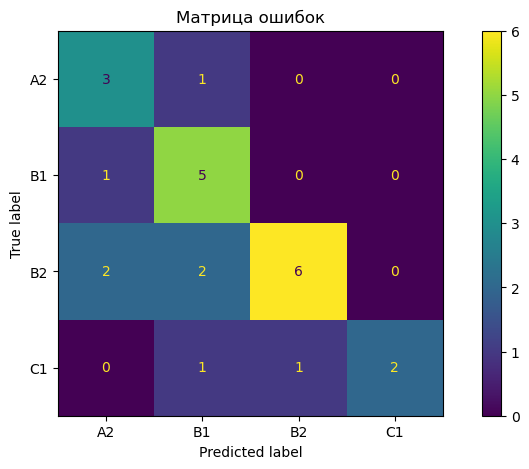

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax = ax)
_ = ax.set_title(f'Матрица ошибок')


In [43]:
best_model_lr = grid_search_lr.best_estimator_
with open('C:/Users/VMP.PC/Documents/Jupyter/Masterskaya/best_model_lr.pkl', "wb") as dataset:
    pickle.dump(best_model_lr, dataset)

**Выводы:**
 Основная цель работы состояла в разработке ML решения для автоматического определения уровня сложности англоязычных фильмов. Набор данных содержит информацию о названии фильма и его уровне сложности.

В начале проекта была проведена подготовка данных. В ходе работы с данными были обнаружены и удалены строки-дубликаты. В данных также были обнаружены множественные метки для одного и того же фильма, поэтому было решено оставить только уровни A2, B1, B2, C1. Фильмы, относящиеся к нескольким уровням были отнесены к единственному варианту. Таким образом, чуть более 100 фильмов относят к категории B2, более 60-ти к B1, около 40-ка фильмов к уровню С1 и более 30 фильмов относятся к А1. В датасете присутствует достаточно сильный дисбаланс данных. 

В ходе работы было произведено чтение субтитров с использованием библиотеки pysrt, также была произведена обработка и токенизирование текста.

В результате проведённого исследования, наилучшей моделью для автоматического определения уровня сложности англоязычных фильмов оказалась модель №1 (LogicsticRegression), так как она показала наилучшие результаты по таким метрикам как: f1 = 0.62, accuracy = 0.59, precision = 0.68, recall = 0.61 и auc-roc = 0.81. Модель №2 (GradientBoostingClassifier) продемонстрировала следующие результаты: f1 = 0.53, accuracy = 0.5, precision = 0.53, recall = 0.55 и auc-roc = 0.76.В ходе работы была попытка создания модели LGBMClassifier, однако её обучение занимает более 2 часов, в следствие чего было решено отказаться от неё. 

Таким образом, модель LogicsticRegression была обучена на тестовой выборке и продемонстрировала следующие результаты: f1 = 0.66.